In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import copy
import random
import time
import itertools

#Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#systems
# from ANCR_v2 import *
from ANCR_v3 import *

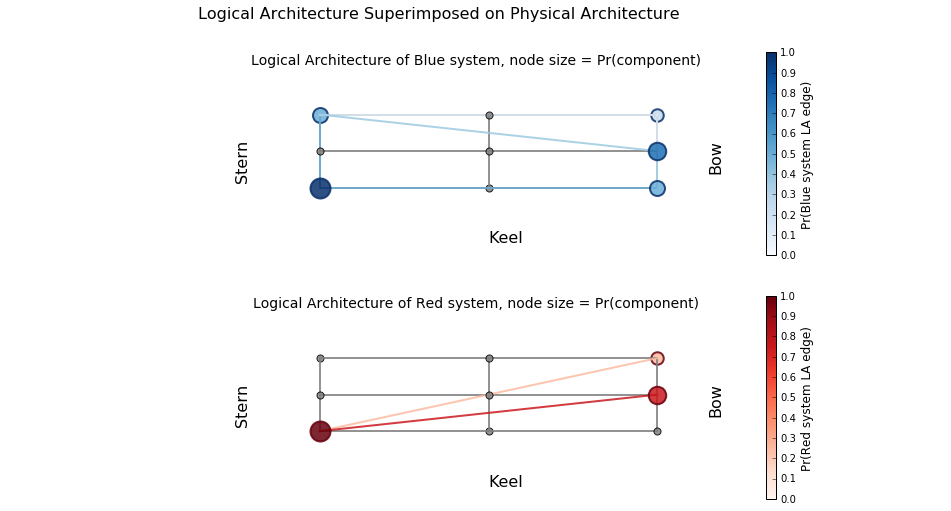

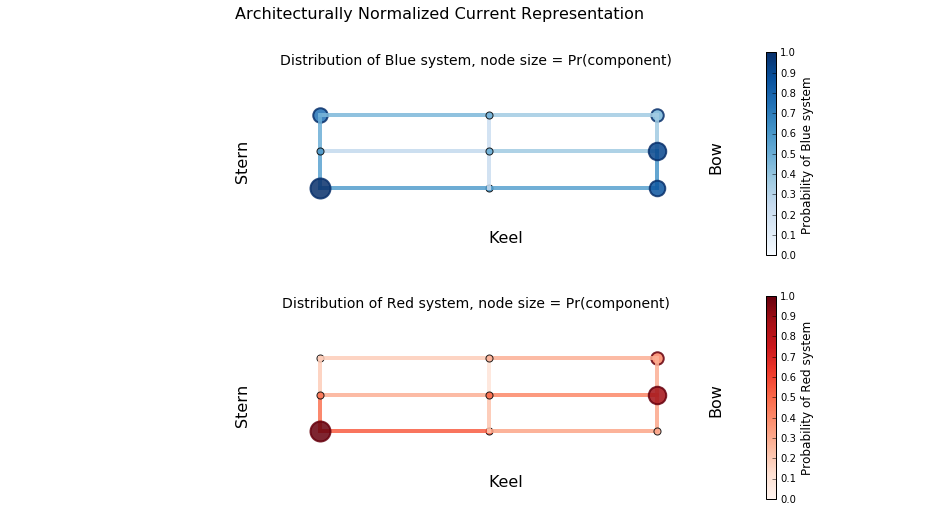

In [2]:
# Physical Architecture
g = nx.grid_graph(dim=[3, 1, 3])

# Logical Architecture
la = {}
la['components'] = {}
la['systems'] = []

# components
c1 = {(0, 0, 0): 1.0}
la['components']['c1'] = {}
la['components']['c1']['loc'] = c1

c2 = {(2, 0, 2): .25, (2, 0, 1): .75}
la['components']['c2'] = {}
la['components']['c2']['loc'] = c2

cu = {(2, 0, 0): 'un', (0, 0, 2): 'un'}  # ,(1,0,0):'un'}
la['components']['cu'] = {}
la['components']['cu']['loc'] = cu

# systems
# power
p = nx.DiGraph()
p.add_node('c1', loc=la['components']['c1']['loc'])
p.add_node('c2', loc=la['components']['c2']['loc'])
p.add_node('cu', loc=la['components']['cu']['loc'])
p.add_edges_from([('c1', 'cu'), ('cu', 'c2')])
la['Blue'] = p
la['systems'].append('Blue')

# cooling
c = nx.DiGraph()
c.add_node('c1', loc=la['components']['c1']['loc'])
c.add_node('c2', loc=la['components']['c1']['loc'])
c.add_edges_from([('c2', 'c1')])
la['Red'] = c
la['systems'].append('Red')

# add unique physical architecture to each edge
ph_ini = 0.5
num_obj = 2
for sys, net in la.iteritems():
    if sys not in la['systems']:
        continue
    for j, k in net.edges():
        # print j,k
        # create unique phyical network for that edge
        g_edge = nx.Graph()
        for a, b in g.edges():
            # print a,b
            i = 0.0  # current
            r = 1.0  # resistance
            ph = [ph_ini for x in xrange(num_obj)]  # pheromone
            h = [1.0 for x in xrange(num_obj)]  # heuristic
            g_edge.add_edge(a, b, i=i, r=r, ph=ph, h=h)  # add edge with data

        for n in g.nodes():
            g_edge.node[n]['i'] = 0.0  # set current for nodes
            ph = [ph_ini for x in xrange(num_obj)]  # pheromone
            h = [1.0 for x in xrange(num_obj)]  # heuristic
            g_edge.node[n]['ph'] = ph
            g_edge.node[n]['h'] = h
        net[j][k]['g'] = g_edge
for comp in la['components']:
    # assign current, pheromones, resistances and heuristics to component locations
    la['components'][comp]['i'] = {}
    la['components'][comp]['r'] = {}
    la['components'][comp]['ph'] = {}
    la['components'][comp]['h'] = {}
    for l in la['components'][comp]['loc']:
        la['components'][comp]['i'][l] = 0.0
        la['components'][comp]['r'][l] = 1.0
        la['components'][comp]['ph'][l] = [ph_ini for x in xrange(num_obj)]  # pheromone
        la['components'][comp]['h'][l] = [1.0 for x in xrange(num_obj)]  # heuristic

# test changing r
# la['components']['cu']['r'][(2,0,0)]=1E-10

ir_la = i_ANCR(g, la)
g_i = project_current_distribution_bus(g, ir_la)

plot=True
if plot:
    plot_setups(g, la, scale=.5, elev=0, angle=-90, factor=2.0)
    plot_current(g_i, ir_la, scale=.5, elev=0, angle=-90, factor=2.0)

In [46]:
print g_i.edges(data=True)

[((0, 0, 2), (1, 0, 2), {'power': 0.390625, 'chill': 0.20000000000000007}), ((0, 0, 2), (0, 0, 1), {'power': 0.47098214285714302, 'chill': 0.20000000000000007}), ((1, 0, 0), (0, 0, 0), {'power': 0.50714285714285678, 'chill': 0.52499999999999991}), ((1, 0, 0), (2, 0, 0), {'power': 0.43526785714285721, 'chill': 0.30000000000000004}), ((1, 0, 0), (1, 0, 1), {'power': 0.22187500000000027, 'chill': 0.22499999999999987}), ((2, 0, 2), (1, 0, 2), {'power': 0.31428571428571428, 'chill': 0.32499999999999996}), ((2, 0, 2), (2, 0, 1), {'power': 0.31428571428571428, 'chill': 0.32500000000000007}), ((0, 0, 1), (0, 0, 0), {'power': 0.5071428571428569, 'chill': 0.47499999999999964}), ((0, 0, 1), (1, 0, 1), {'power': 0.24687500000000007, 'chill': 0.27500000000000013}), ((1, 0, 1), (1, 0, 2), {'power': 0.203125, 'chill': 0.125}), ((1, 0, 1), (2, 0, 1), {'power': 0.33437499999999987, 'chill': 0.37499999999999978}), ((2, 0, 1), (2, 0, 0), {'power': 0.51562499999999978, 'chill': 0.29999999999999971})]


In [4]:
data_e={}
data_e['edges']=[x for x in g_i.edges()]
data_e['Red']=[d['Red'] for i,j,d in g_i.edges(data=True)]
data_e['Blue']=[d['Blue'] for i,j,d in g_i.edges(data=True)]
data_e['all']=[1.0-(1.0-d['Blue'])*(1.0-d['Red']) for i,j,d in g_i.edges(data=True)]

df_e=pd.DataFrame(data_e)
df_e=df_e.set_index('edges')
print df_e

data_n={}
data_n['nodes']=[x for x in g_i.nodes()]
data_n['Red']=[d['Red'] for n,d in g_i.nodes(data=True)]
data_n['Blue']=[d['Blue'] for n,d in g_i.nodes(data=True)]
data_n['all']=[1.0-(1.0-d['Blue'])*(1.0-d['Red']) for n,d in g_i.nodes(data=True)]

df_n=pd.DataFrame(data_n)
df_n=df_n.set_index('nodes')
print df_n

                            Blue      Red       all
edges                                              
((0, 0, 2), (1, 0, 2))  0.454719  0.18750  0.556960
((0, 0, 2), (0, 0, 1))  0.498067  0.18750  0.592179
((1, 0, 0), (0, 0, 0))  0.572589  0.53125  0.799651
((1, 0, 0), (2, 0, 0))  0.555345  0.31250  0.694300
((1, 0, 0), (1, 0, 1))  0.231580  0.21875  0.399672
((2, 0, 2), (1, 0, 2))  0.359375  0.28125  0.539551
((2, 0, 2), (2, 0, 1))  0.365234  0.28125  0.543762
((0, 0, 1), (0, 0, 0))  0.549062  0.46875  0.760439
((0, 0, 1), (1, 0, 1))  0.261480  0.28125  0.469188
((1, 0, 1), (1, 0, 2))  0.219682  0.09375  0.292837
((1, 0, 1), (2, 0, 1))  0.369180  0.40625  0.625451
((2, 0, 1), (2, 0, 0))  0.605389  0.31250  0.728705
               Blue      Red       all
nodes                                 
(0, 0, 2)  0.748622  0.18750  0.795756
(1, 0, 0)  0.638303  0.53125  0.830455
(2, 0, 2)  0.471680  0.40625  0.686310
(0, 0, 1)  0.613523  0.46875  0.794684
(1, 0, 1)  0.500279  0.50000  0.750140

In [5]:
for c in ir_la['components']:
    print c, ir_la['components'][c]['i']

c2 {(2, 0, 2): 0.25, (2, 0, 1): 0.75}
c1 {(0, 0, 0): 1.0}
cu {(2, 0, 0): 0.55357142857142883, (0, 0, 2): 0.44642857142857123}


In [49]:
print ir_la


{'power': <networkx.classes.digraph.DiGraph object at 0x000000000BEB6F28>, 'systems': ['power', 'chill'], 'components': {'c2': {'i': {(2, 0, 2): 0.30769230769230776, (2, 0, 1): 0.6923076923076923}, 'loc': {(2, 0, 2): 0.4, (2, 0, 1): 0.6}, 'ph': {(2, 0, 2): [0.5, 0.5], (2, 0, 1): [0.5, 0.5]}, 'r': {(2, 0, 2): 1.0, (2, 0, 1): 1.0}, 'h': {(2, 0, 2): [1.0, 1.0], (2, 0, 1): [1.0, 1.0]}}, 'c1': {'i': {(0, 0, 0): 1.0}, 'loc': {(0, 0, 0): 1.0}, 'ph': {(0, 0, 0): [0.5, 0.5]}, 'r': {(0, 0, 0): 1.0}, 'h': {(0, 0, 0): [1.0, 1.0]}}, 'cu': {'i': {(2, 0, 0): 0.54285714285714304, (0, 0, 2): 0.45714285714285702}, 'loc': {(2, 0, 0): 'un', (0, 0, 2): 'un'}, 'ph': {(2, 0, 0): [0.5, 0.5], (0, 0, 2): [0.5, 0.5]}, 'r': {(2, 0, 0): 1.0, (0, 0, 2): 1.0}, 'h': {(2, 0, 0): [1.0, 1.0], (0, 0, 2): [1.0, 1.0]}}}, 'chill': <networkx.classes.digraph.DiGraph object at 0x000000000BEB6E10>}


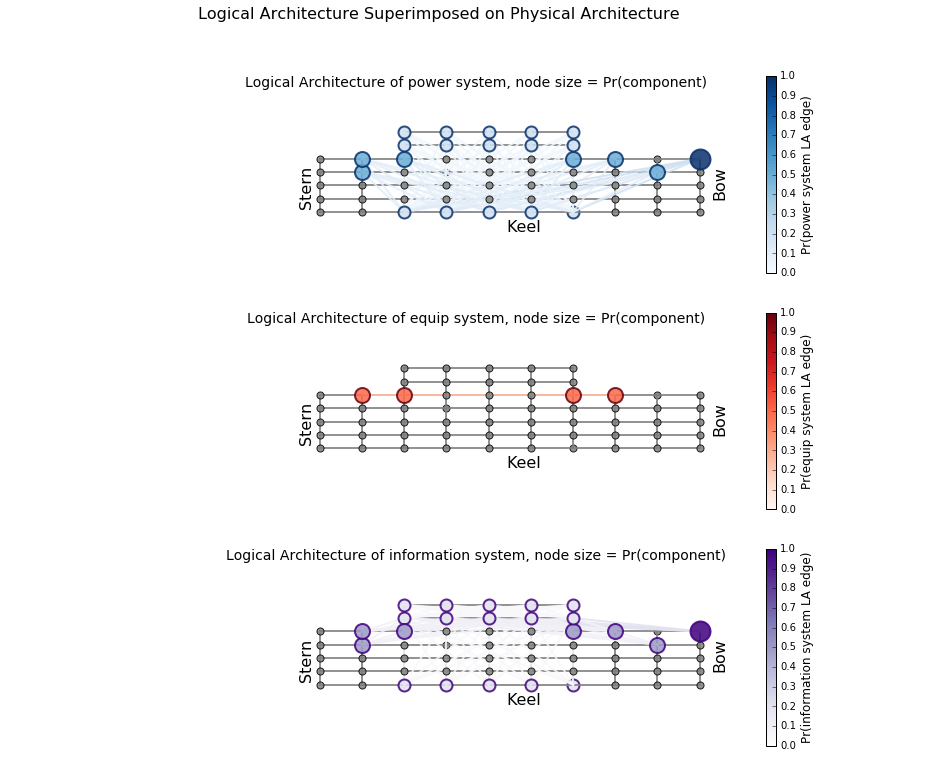

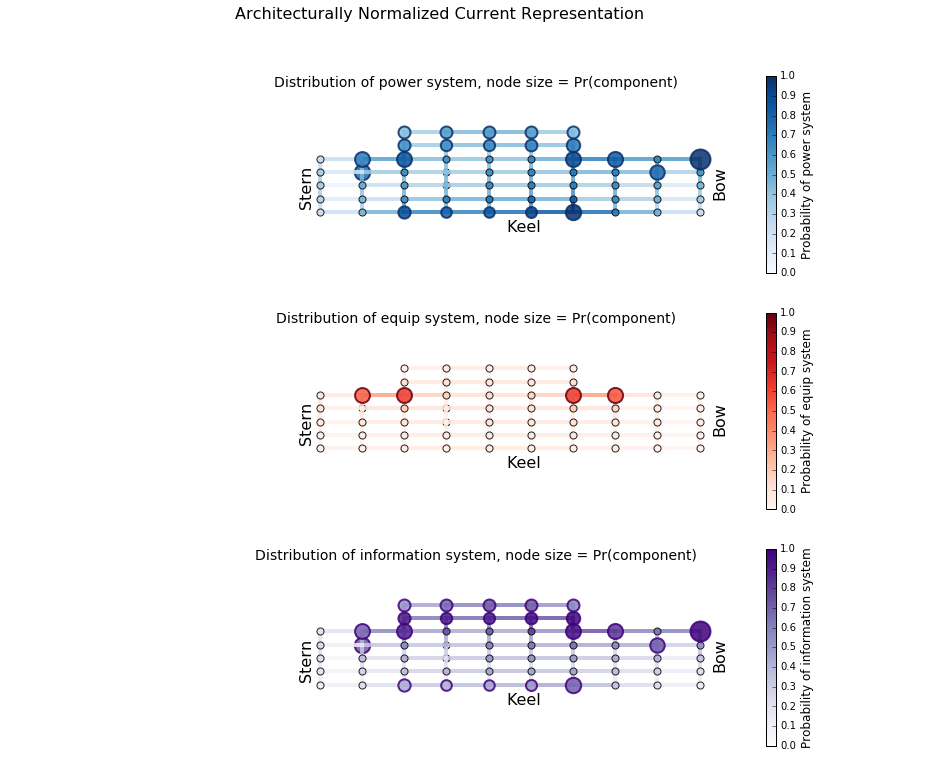

In [15]:
"""
Define Physical and logical architectures for van Oers
"""

#Physical
g=nx.grid_graph(dim=[10,1,7])
g.remove_nodes_from([(0,0,5),(0,0,6),(1,0,5),(1,0,6),(7,0,5),(7,0,6),(8,0,5),(8,0,6),(9,0,5),(9,0,6)])
# print nx.is_connected(g)

#Components and locations - first configuration
pp={(2,0,0):0.0,(3,0,0):0.0,(4,0,0):0.0,(5,0,0):1.0,(6,0,0):0.0}
VLS={(8,0,3):1.0,(1,0,3):0.0}
bridge={(2,0,5):0.0,(3,0,5):0.0,(4,0,5):0.0,(5,0,5):0.0,(6,0,5):1.0}
fdeck={(1,0,4):1.0,(2,0,4):0.0,(6,0,4):0.0,(7,0,4):0.0}
hangar={(3,0,4):1.0,(4,0,4):0.0,(5,0,4):0.0,}
radar={(2,0,6):0.0,(3,0,6):0.0,(4,0,6):0.0,(5,0,6):1.0,(6,0,6):0.0}
gun={(8,0,4):1.0,(9,0,4):0.0}

#Swtiched
s_bridge={(2,0,5):1.0,(3,0,5):0.0,(4,0,5):0.0,(5,0,5):0.0,(6,0,5):0.0}
s_fdeck={(1,0,4):0.0,(2,0,4):0.0,(6,0,4):1.0,(7,0,4):0.0}
s_VLS={(8,0,3):0.0,(1,0,3):1.0}

#Components and unknown
# u_pp={(2,0,0):'un',(3,0,0):'un',(4,0,0):'un',(5,0,0):'un',(6,0,0):'un'}
# u_VLS={(8,0,3):'un',(1,0,3):'un'}
# u_bridge={(2,0,5):'un',(3,0,5):'un',(4,0,5):'un',(5,0,5):'un',(6,0,5):'un'}
# u_fdeck={(1,0,4):'un',(2,0,4):'un',(6,0,4):'un',(7,0,4):'un'}
# u_hangar={(3,0,4):'un',(4,0,4):'un',(5,0,4):'un'}
# u_radar={(2,0,6):'un',(3,0,6):'un',(4,0,6):'un',(5,0,6):'un',(6,0,6):'un'}
# u_gun={(8,0,4):'un',(9,0,4):'un'}

u_pp={(2,0,0):'un',(3,0,0):'un',(4,0,0):'un',(5,0,0):'un',(6,0,0):'un'}
u_VLS={(8,0,3):'un',(1,0,3):'un'}
u_bridge={(2,0,5):'un',(3,0,5):'un',(4,0,5):'un',(5,0,5):'un',(6,0,5):'un'}
# u_fdeck={(1,0,4):'un',(2,0,4):'un',(6,0,4):'un',(7,0,4):'un'}
u_fdeck={(1,0,4):'un',(7,0,4):'un'}
u_hangar={(2,0,4):'un',(6,0,4):'un'}
u_radar={(2,0,6):'un',(3,0,6):'un',(4,0,6):'un',(5,0,6):'un',(6,0,6):'un'}
u_gun={(9,0,4):'un'}



#Logical
la={}

#Define components
la['components']={}

#Power plant
la['components']['propulsion plant']={}
la['components']['propulsion plant']['loc']=u_pp

#Vertical Launch System
la['components']['VLS']={}
la['components']['VLS']['loc']=u_VLS

#Bridge
la['components']['bridge']={}
la['components']['bridge']['loc']=u_bridge

#Flight Deck
la['components']['flight deck']={}
la['components']['flight deck']['loc']=u_fdeck

#Hangar
la['components']['hangar']={}
la['components']['hangar']['loc']=u_hangar

#Radar
la['components']['radar mast']={}
la['components']['radar mast']['loc']=u_radar

#Gun
la['components']['fwd. gun']={}
la['components']['fwd. gun']['loc']=u_gun



#Logical systems
la['systems']=[]

#power
la['systems'].append('power')

p=nx.DiGraph()
p.add_node('propulsion plant',loc=la['components']['propulsion plant']['loc'])
p.add_node('VLS',loc=la['components']['VLS']['loc'])
p.add_node('bridge',loc=la['components']['bridge']['loc'])
p.add_node('flight deck',loc=la['components']['flight deck']['loc'])
p.add_node('hangar',loc=la['components']['hangar']['loc'])
p.add_node('radar mast',loc=la['components']['radar mast']['loc'])
p.add_node('fwd. gun',loc=la['components']['fwd. gun']['loc'])

p.add_edges_from([('propulsion plant',x) for x in p.nodes()])
p.remove_edge('propulsion plant','propulsion plant')

la['power']=p



#equipment
la['systems'].append('equip')
e=p.copy()
e.remove_edges_from(e.edges())
e.remove_nodes_from(['propulsion plant','VLS','bridge','radar mast','fwd. gun'])
e.add_edge('hangar','flight deck')


# print e.nodes(data=True)
# print e.edges(data=True)

la['equip']=e


#information
la['systems'].append('information')
i=p.copy()
i.remove_edges_from(i.edges())
# i.remove_nodes_from(['propulsion plant'])
i.add_edges_from([('radar mast','bridge'),('bridge','fwd. gun'),
                  ('bridge','hangar'),('bridge','flight deck'),
                  ('bridge','VLS'),('bridge','propulsion plant')])

la['information']=i

#image
# la['systems'].append('image')
# image=nx.DiGraph()
# la['image']=image

la=setup_LA(g,la)
ir_la = i_ANCR(g, la)
g_i = project_current_distribution_bus(g, ir_la)
plot_setups(g, la, scale=.5, elev=0, angle=-90, factor=2.0)
plot_current(g_i, ir_la, scale=.5, elev=0, angle=-90, factor=2.0)

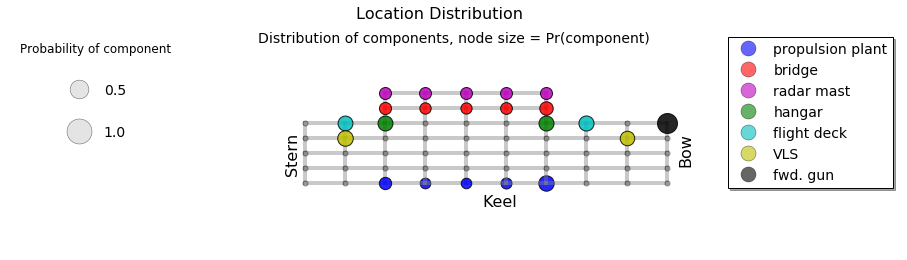

In [7]:
plot_locations2(g_i,
                ir_la,
                ['propulsion plant','bridge','radar mast','hangar','flight deck','VLS','fwd. gun'],
                scale=.5,
                elev=0,
                angle=-90,
                factor=2.0)

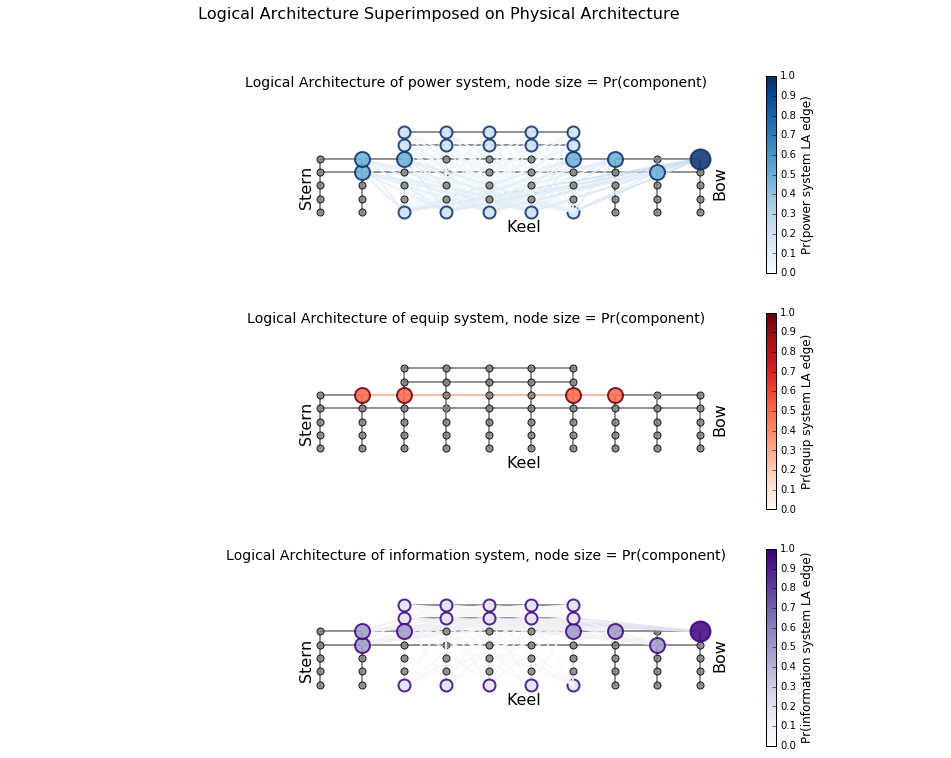

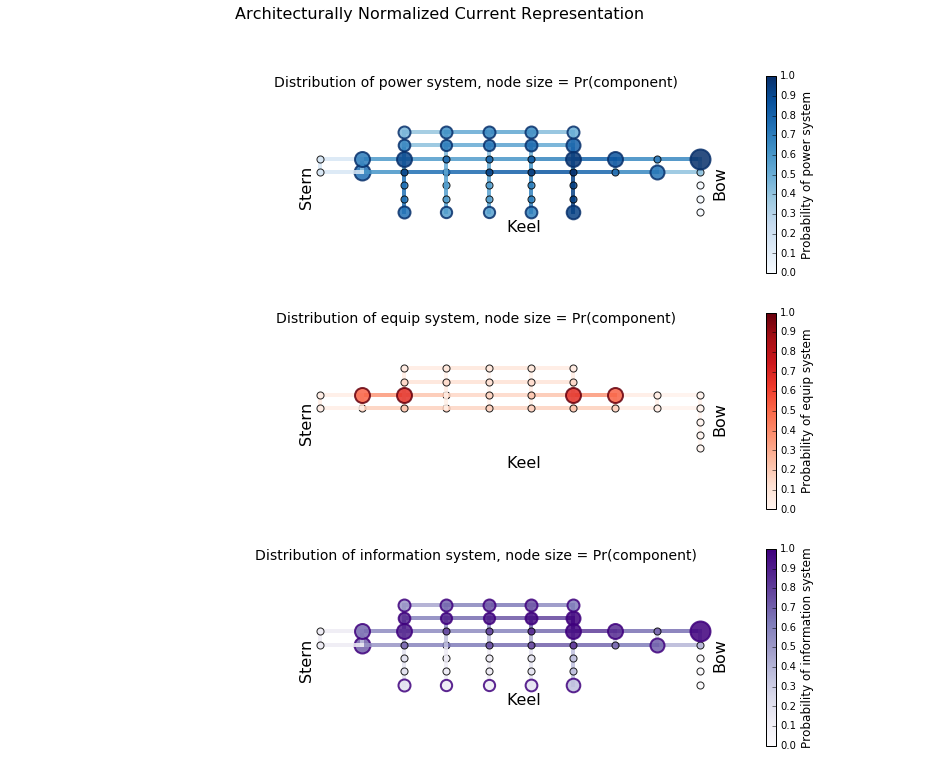

In [20]:
"""
Define Physical and logical architectures for van Oers
"""

#Physical
g=nx.grid_graph(dim=[10,1,7])
g.remove_nodes_from([(0,0,5),(0,0,6),(1,0,5),(1,0,6),(7,0,5),(7,0,6),(8,0,5),(8,0,6),(9,0,5),(9,0,6)])

#remove nodes for watertight bulkheads
bh_height=3
rem_list=[]
for i,j in g.edges():
    #check if horizontal edge
    if i[2]==j[2]:
        #check if below bh height
        if i[2]<bh_height:
            rem_list.append((i,j))

g.remove_edges_from(rem_list)
# print nx.is_connected(g)

#Components and locations - first configuration
pp={(2,0,0):0.0,(3,0,0):0.0,(4,0,0):0.0,(5,0,0):1.0,(6,0,0):0.0}
VLS={(8,0,3):1.0,(1,0,3):0.0}
bridge={(2,0,5):0.0,(3,0,5):0.0,(4,0,5):0.0,(5,0,5):0.0,(6,0,5):1.0}
fdeck={(1,0,4):1.0,(2,0,4):0.0,(6,0,4):0.0,(7,0,4):0.0}
hangar={(3,0,4):1.0,(4,0,4):0.0,(5,0,4):0.0,}
radar={(2,0,6):0.0,(3,0,6):0.0,(4,0,6):0.0,(5,0,6):1.0,(6,0,6):0.0}
gun={(8,0,4):1.0,(9,0,4):0.0}

#Swtiched
s_bridge={(2,0,5):1.0,(3,0,5):0.0,(4,0,5):0.0,(5,0,5):0.0,(6,0,5):0.0}
s_fdeck={(1,0,4):0.0,(2,0,4):0.0,(6,0,4):1.0,(7,0,4):0.0}
s_VLS={(8,0,3):0.0,(1,0,3):1.0}

#Components and unknown
# u_pp={(2,0,0):'un',(3,0,0):'un',(4,0,0):'un',(5,0,0):'un',(6,0,0):'un'}
# u_VLS={(8,0,3):'un',(1,0,3):'un'}
# u_bridge={(2,0,5):'un',(3,0,5):'un',(4,0,5):'un',(5,0,5):'un',(6,0,5):'un'}
# u_fdeck={(1,0,4):'un',(2,0,4):'un',(6,0,4):'un',(7,0,4):'un'}
# u_hangar={(3,0,4):'un',(4,0,4):'un',(5,0,4):'un'}
# u_radar={(2,0,6):'un',(3,0,6):'un',(4,0,6):'un',(5,0,6):'un',(6,0,6):'un'}
# u_gun={(8,0,4):'un',(9,0,4):'un'}

u_pp={(2,0,0):'un',(3,0,0):'un',(4,0,0):'un',(5,0,0):'un',(6,0,0):'un'}
u_VLS={(8,0,3):'un',(1,0,3):'un'}
u_bridge={(2,0,5):'un',(3,0,5):'un',(4,0,5):'un',(5,0,5):'un',(6,0,5):'un'}
# u_fdeck={(1,0,4):'un',(2,0,4):'un',(6,0,4):'un',(7,0,4):'un'}
u_fdeck={(1,0,4):'un',(7,0,4):'un'}
u_hangar={(2,0,4):'un',(6,0,4):'un'}
u_radar={(2,0,6):'un',(3,0,6):'un',(4,0,6):'un',(5,0,6):'un',(6,0,6):'un'}
u_gun={(9,0,4):'un'}



#Logical
la={}

#Define components
la['components']={}

#Power plant
la['components']['propulsion plant']={}
la['components']['propulsion plant']['loc']=u_pp

#Vertical Launch System
la['components']['VLS']={}
la['components']['VLS']['loc']=u_VLS

#Bridge
la['components']['bridge']={}
la['components']['bridge']['loc']=u_bridge

#Flight Deck
la['components']['flight deck']={}
la['components']['flight deck']['loc']=u_fdeck

#Hangar
la['components']['hangar']={}
la['components']['hangar']['loc']=u_hangar

#Radar
la['components']['radar mast']={}
la['components']['radar mast']['loc']=u_radar

#Gun
la['components']['fwd. gun']={}
la['components']['fwd. gun']['loc']=u_gun



#Logical systems
la['systems']=[]

#power
la['systems'].append('power')

p=nx.DiGraph()
p.add_node('propulsion plant',loc=la['components']['propulsion plant']['loc'])
p.add_node('VLS',loc=la['components']['VLS']['loc'])
p.add_node('bridge',loc=la['components']['bridge']['loc'])
p.add_node('flight deck',loc=la['components']['flight deck']['loc'])
p.add_node('hangar',loc=la['components']['hangar']['loc'])
p.add_node('radar mast',loc=la['components']['radar mast']['loc'])
p.add_node('fwd. gun',loc=la['components']['fwd. gun']['loc'])

p.add_edges_from([('propulsion plant',x) for x in p.nodes()])
p.remove_edge('propulsion plant','propulsion plant')

la['power']=p



#equipment
la['systems'].append('equip')
e=p.copy()
e.remove_edges_from(e.edges())
e.remove_nodes_from(['propulsion plant','VLS','bridge','radar mast','fwd. gun'])
e.add_edge('hangar','flight deck')


# print e.nodes(data=True)
# print e.edges(data=True)

la['equip']=e


#information
la['systems'].append('information')
i=p.copy()
i.remove_edges_from(i.edges())
# i.remove_nodes_from(['propulsion plant'])
i.add_edges_from([('radar mast','bridge'),('bridge','fwd. gun'),
                  ('bridge','hangar'),('bridge','flight deck'),
                  ('bridge','VLS'),('bridge','propulsion plant')])

la['information']=i

#image
# la['systems'].append('image')
# image=nx.DiGraph()
# la['image']=image

la=setup_LA(g,la)
ir_la = i_ANCR(g, la)
g_i = project_current_distribution_bus(g, ir_la)
plot_setups(g, la, scale=.5, elev=0, angle=-90, factor=2.0)
plot_current(g_i, ir_la, scale=.5, elev=0, angle=-90, factor=2.0)

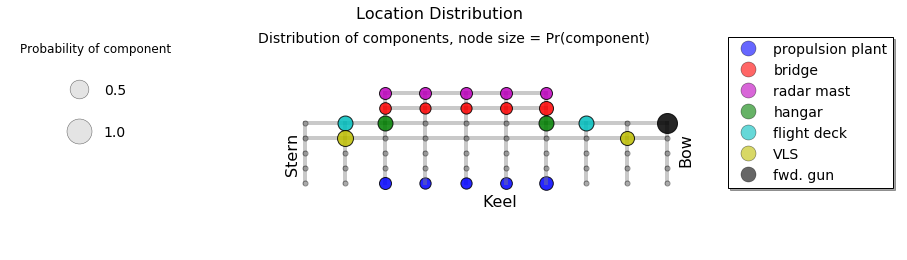

In [15]:
plot_locations2(g_i,
                ir_la,
                ['propulsion plant','bridge','radar mast','hangar','flight deck','VLS','fwd. gun'],
                scale=.5,
                elev=0,
                angle=-90,
                factor=2.0)

In [13]:
for c in ir_la['components']:
    print c,ir_la['components'][c]['i']
    
print 'power'
    
targets=[(2,0,0),(3,0,0),(4,0,0),(5,0,0),(6,0,0)]
for i,j in g_i.edges():
    if (i in targets) or (j in targets): 
        print (i,j), g_i[i][j]['power']

print 'information'
for i,j in g_i.edges():
    if (i in targets) or (j in targets): 
        print (i,j), g_i[i][j]['information']


bridge {(2, 0, 5): 0.16705352306231366, (4, 0, 5): 0.11904686469595167, (3, 0, 5): 0.11696539971010521, (6, 0, 5): 0.40423724388389809, (5, 0, 5): 0.19269696864773142}
flight deck {(7, 0, 4): 0.50073523710563672, (1, 0, 4): 0.49926476289436339}
propulsion plant {(6, 0, 0): 0.36242806769205982, (3, 0, 0): 0.13171322581128225, (5, 0, 0): 0.17654358398727599, (2, 0, 0): 0.20256177385587179, (4, 0, 0): 0.12675334865351015}
fwd. gun {(9, 0, 4): 1.0}
radar mast {(5, 0, 6): 0.19968795805497999, (6, 0, 6): 0.20070441091141936, (3, 0, 6): 0.19968065641915692, (4, 0, 6): 0.19923690866207694, (2, 0, 6): 0.20069006595236671}
VLS {(1, 0, 3): 0.59814610176838834, (8, 0, 3): 0.40185389823161166}
hangar {(2, 0, 4): 0.49993390511586261, (6, 0, 4): 0.50006609488413756}
power
((6, 0, 1), (6, 0, 0)) 0.932830032257
((4, 0, 1), (4, 0, 0)) 0.556573571786
((2, 0, 1), (2, 0, 0)) 0.742852502947
((5, 0, 0), (5, 0, 1)) 0.688223263793
((3, 0, 0), (3, 0, 1)) 0.571472087594
information
((6, 0, 1), (6, 0, 0)) 0.36242

In [8]:
for c in ir_la['components']:
    print c,ir_la['components'][c]['i']

targets=[(2,0,0),(3,0,0),(4,0,0),(5,0,0),(6,0,0)]
for i,j in g_i.edges():
    if (i in targets) or (j in targets): 
        print (i,j), g_i[i][j]['power']

bridge {(2, 0, 5): 0.21257914716205922, (4, 0, 5): 0.12515084526532527, (3, 0, 5): 0.13684441870522254, (6, 0, 5): 0.34587752630191071, (5, 0, 5): 0.17954806256548231}
flight deck {(7, 0, 4): 0.51031877297343353, (1, 0, 4): 0.48968122702656636}
propulsion plant {(6, 0, 0): 0.54379272006818413, (3, 0, 0): 0.067068305476950821, (5, 0, 0): 0.10374418825246849, (2, 0, 0): 0.22988144192936225, (4, 0, 0): 0.055513344273034386}
fwd. gun {(9, 0, 4): 1.0}
radar mast {(5, 0, 6): 0.19926350506478885, (6, 0, 6): 0.2029634383243657, (3, 0, 6): 0.19863679093284325, (4, 0, 6): 0.19729348294810056, (2, 0, 6): 0.20184278272990164}
VLS {(1, 0, 3): 0.55158483303619854, (8, 0, 3): 0.44841516696380157}
hangar {(2, 0, 4): 0.49805160557013478, (6, 0, 4): 0.50194839442986516}
((1, 0, 0), (2, 0, 0)) 0.47769398874
((6, 0, 1), (6, 0, 0)) 0.796771295541
((6, 0, 0), (5, 0, 0)) 0.83333265942
((6, 0, 0), (7, 0, 0)) 0.746429059909
((4, 0, 1), (4, 0, 0)) 0.469593386026
((4, 0, 0), (3, 0, 0)) 0.679574243831
((4, 0, 0),

In [19]:
print 'high'
targets=[(2,0,1),(3,0,1),(4,0,1),(5,0,1),(6,0,1)]
for i,j in g_i.edges():
    if (i in targets) and (j in targets): 
        print (i,j), g_i[i][j]['power']

print 'low'
targets=[(2,0,0),(3,0,0),(4,0,0),(5,0,0),(6,0,0)]
for i,j in g_i.edges():
    if (i in targets) and (j in targets): 
        print (i,j), g_i[i][j]['power']

high/
((6, 0, 1), (5, 0, 1)) 0.475193655483
((4, 0, 1), (5, 0, 1)) 0.510091550672
((4, 0, 1), (3, 0, 1)) 0.481869887295
((2, 0, 1), (3, 0, 1)) 0.406188939052
low
((6, 0, 0), (5, 0, 0)) 0.83333265942
((4, 0, 0), (3, 0, 0)) 0.679574243831
((4, 0, 0), (5, 0, 0)) 0.740904951769
((2, 0, 0), (3, 0, 0)) 0.659605355377


In [22]:
i_la = i_arrange_g(g, la)
for c in i_la['components']:
    print c, i_la['components'][c]['i']

bridge {(2, 0, 5): 0.16705352306231366, (4, 0, 5): 0.11904686469595167, (3, 0, 5): 0.11696539971010521, (6, 0, 5): 0.40423724388389809, (5, 0, 5): 0.19269696864773142}
flight deck {(7, 0, 4): 0.50073523710563672, (1, 0, 4): 0.49926476289436339}
propulsion plant {(6, 0, 0): 0.36242806769205982, (3, 0, 0): 0.13171322581128225, (5, 0, 0): 0.17654358398727599, (2, 0, 0): 0.20256177385587179, (4, 0, 0): 0.12675334865351015}
fwd. gun {(9, 0, 4): 1.0}
radar mast {(5, 0, 6): 0.19968795805497999, (6, 0, 6): 0.20070441091141936, (3, 0, 6): 0.19968065641915692, (4, 0, 6): 0.19923690866207694, (2, 0, 6): 0.20069006595236671}
VLS {(1, 0, 3): 0.59814610176838834, (8, 0, 3): 0.40185389823161166}
hangar {(2, 0, 4): 0.49993390511586261, (6, 0, 4): 0.50006609488413756}


In [33]:
E_list=i_la['equip'].edges()

#Get set of possible location pairs
loc_pairs=set()

#iterate through each component locations to get the possible location pairs
for u,v in E_list:
    u_locs=i_la['components'][u]['loc'].keys()
    v_locs=i_la['components'][v]['loc'].keys()
    pairs=list(itertools.product(*[u_locs,v_locs]))
    loc_pairs.update(pairs)
    
#print loc_pairs

#get current distributions for each location pair
current_pairs={}
for (x,y) in loc_pairs:
    I=current_st(g,x,y)
    current_pairs[(x,y)]=I
    
# print current_pairs

#get all possible arrangments and their probability
#identify components
components=set(itertools.chain.from_iterable(E_list))
print components

#map each component to an index  
index_to_component_map=dict(zip(xrange(len(components)),components))
component_to_index_map=dict((y,x) for x,y in index_to_component_map.iteritems())
print index_to_component_map


#use indexes to generate list of lists for component locations
possible_locations=[]
for index in xrange(len(components)):
    c=index_to_component_map[index]
    possible_locations.append(i_la['components'][c]['loc'].keys())
print possible_locations

#get possible combinations of locations
arrangement_list=list(itertools.product(*possible_locations))
#print arrangement_list

#initalize results dictionary
p=dict.fromkeys(g.nodes()+g.edges(),0.0)

#iterate through arrangements to populate results
for n in g.nodes():
    #nodes first
    #iterate through arrangements
    for a in arrangement_list:
        p_arrange=1.0 #get probability of the arrangement a
        for a_index in xrange(len(a)):
            loc_at_index=a[a_index] #location at the index
            c_at_index=index_to_component_map[a_index] #component at the index
            p_arrange*=i_la['components'][c_at_index]['i'][loc_at_index]
        #print a, p_arrange
        
        #get probability that the element is not used by any logical connection in E
        p_ele_not_used_a=1.0
        for u,v in E_list:
            #get the arrangement's component assignment
            u_index=component_to_index_map[u] #get index in arrangement
            v_index=component_to_index_map[v] #get index in arrangement
            u_loc=a[u_index] #location of u in arrangement
            v_loc=a[v_index] #location of v in arrangement
            
            #get current value for node n
            #first get right key
            if (u_loc,v_loc) in current_pairs:
                key=(u_loc,v_loc)
            else:
                key=(v_loc,u_loc)
            p_ele_not_used_a*=(1.0-current_pairs[key][n]) #assemble probability that node is not used
        
        #get probability the element was used by any logical connection in E
        p_ele_used_a=1.0-p_ele_not_used_a
        
        #weight use by the probability of the arrangement
        p_ele_used=p_ele_used_a*p_arrange
        
        #add probability of use to the results dictionary
        p[n]+=p_ele_used

for i,j in g.edges():
    #nodes first
    #iterate through arrangements
    for a in arrangement_list:
        p_arrange=1.0 #get probability of the arrangement a
        for a_index in xrange(len(a)):
            loc_at_index=a[a_index] #location at the index
            c_at_index=index_to_component_map[a_index] #component at the index
            p_arrange*=i_la['components'][c_at_index]['i'][loc_at_index]
        #print a, p_arrange
        
        #get probability that the element is not used by any logical connection in E
        p_ele_not_used_a=1.0
        for u,v in E_list:
            #get the arrangement's component assignment
            u_index=component_to_index_map[u] #get index in arrangement
            v_index=component_to_index_map[v] #get index in arrangement
            u_loc=a[u_index] #location of u in arrangement
            v_loc=a[v_index] #location of v in arrangement
            
            #get current value for node n
            #first get right key
            if (u_loc,v_loc) in current_pairs:
                key=(u_loc,v_loc)
            else:
                key=(v_loc,u_loc)
            
            #second get right edge key
            if (i,j) in current_pairs[key]:
                edge_key=(i,j)
            else:
                edge_key=(j,i)
            p_ele_not_used_a*=(1.0-current_pairs[key][edge_key]) #assemble probability that node is not used
        
        #get probability the element was used by any logical connection in E
        p_ele_used_a=1.0-p_ele_not_used_a
        
        #weight use by the probability of the arrangement
        p_ele_used=p_ele_used_a*p_arrange
        
        #add probability of use to the results dictionary
        #get the key
        if (i,j) in p:
            edge_key=(i,j)
        else:
            edge_key=(j,i)
                
        p[edge_key]+=p_ele_used
        
        
# for c in i_la['components']:
#     for loc in i_la['components']['i']:keys()


set(['flight deck', 'hangar'])
{0: 'flight deck', 1: 'hangar'}
[[(7, 0, 4), (1, 0, 4)], [(2, 0, 4), (6, 0, 4)]]


In [34]:
for c in i_la['components']:
    print c, i_la['components'][c]['i']
    
#node check
targets=[(2,0,1),(3,0,1),(4,0,1),(5,0,1),(6,0,1)]
for n in g.nodes():
    if n in targets: 
        print n, p[n]
        
#edge check
targets=[(2,0,0),(3,0,0),(4,0,0),(5,0,0),(6,0,0)]
for i,j in g.edges():
    if (i in targets) or (j in targets): 
        print (i,j), p[(i,j)]

bridge {(2, 0, 5): 0.16705352306231366, (4, 0, 5): 0.11904686469595167, (3, 0, 5): 0.11696539971010521, (6, 0, 5): 0.40423724388389809, (5, 0, 5): 0.19269696864773142}
flight deck {(7, 0, 4): 0.50073523710563672, (1, 0, 4): 0.49926476289436339}
propulsion plant {(6, 0, 0): 0.36242806769205982, (3, 0, 0): 0.13171322581128225, (5, 0, 0): 0.17654358398727599, (2, 0, 0): 0.20256177385587179, (4, 0, 0): 0.12675334865351015}
fwd. gun {(9, 0, 4): 1.0}
radar mast {(5, 0, 6): 0.19968795805497999, (6, 0, 6): 0.20070441091141936, (3, 0, 6): 0.19968065641915692, (4, 0, 6): 0.19923690866207694, (2, 0, 6): 0.20069006595236671}
VLS {(1, 0, 3): 0.59814610176838834, (8, 0, 3): 0.40185389823161166}
hangar {(2, 0, 4): 0.49993390511586261, (6, 0, 4): 0.50006609488413756}
(2, 0, 1) 0.0
(6, 0, 1) 0.0
(5, 0, 1) 0.0
(4, 0, 1) 0.0
(3, 0, 1) 0.0
((6, 0, 1), (6, 0, 0)) 0.0
((4, 0, 1), (4, 0, 0)) 0.0
((2, 0, 1), (2, 0, 0)) 0.0
((5, 0, 0), (5, 0, 1)) 0.0
((3, 0, 0), (3, 0, 1)) 0.0
